# 🎯 Support Vector Regression (SVR) - Non-Linear Regression with Kernels

**Module 01: Regression Algorithms (Supervised Learning)**

---

## 🎯 Learning Objectives

By the end of this notebook, you will understand:

1. **SVR Foundation** - How SVR differs from linear regression
2. **Epsilon-Insensitive Loss** - The tube concept in SVR
3. **Kernel Trick** - Transform data to capture non-linear relationships
4. **Kernel Types** - Linear, Polynomial (poly), RBF (Gaussian), Sigmoid
5. **Hyperparameter Tuning** - C, epsilon, gamma optimization
6. **Production Deployment** - When SVR outperforms linear models

## 📚 Section 1: Theoretical Foundation

### What is Support Vector Regression (SVR)?

**Linear Regression** tries to fit data by minimizing error:
```
Minimize: Σ(yᵢ - ŷᵢ)²
```

**SVR** tries to fit data within an **epsilon (ε) tube**:
```
Minimize: (1/2)||w||² + C × Σ(ξᵢ + ξᵢ*)
subject to: |yᵢ - ŷᵢ| ≤ ε + ξᵢ
```

---

### 🔵 The Epsilon-Insensitive Tube Concept

**Key Idea:** Errors smaller than ε are **ignored** (considered "good enough")

```
     |
     |     ← Upper boundary (ŷ + ε)
     |  •  ← Points inside tube = NO penalty
     |━━━━ ← Regression line (ŷ)
     |  •  ← Points inside tube = NO penalty
     |     ← Lower boundary (ŷ - ε)
     |
   • |     ← Point outside tube = Penalized
```

**Benefits:**
- Robust to outliers (points inside tube don't affect model)
- Sparse solution (only support vectors matter)
- Flexible margin control via epsilon (ε)

---

### 🎨 The Kernel Trick - Capturing Non-Linearity

**Problem:** Linear models can't fit curved relationships

**Solution:** Transform data into higher dimensions where it becomes linear!

**Kernel Function:** K(x, x') computes similarity between points

---

### 📊 Kernel Types in SVR

#### 1. **Linear Kernel**
```
K(x, x') = x · x'
```
- No transformation
- Use when: Relationship is linear
- Fastest computation

#### 2. **Polynomial Kernel**
```
K(x, x') = (γ·x·x' + r)^d
```
- Parameters: degree (d), gamma (γ), coef0 (r)
- Use when: Polynomial trends exist
- Can capture curved relationships

#### 3. **RBF (Radial Basis Function) / Gaussian Kernel** ⭐ Most Popular
```
K(x, x') = exp(-γ||x - x'||²)
```
- Parameter: gamma (γ) - controls curve smoothness
- Use when: Unknown non-linear relationship
- Works well for most datasets
- High γ = Overfitting risk (complex curves)
- Low γ = Underfitting (too smooth)

#### 4. **Sigmoid Kernel**
```
K(x, x') = tanh(γ·x·x' + r)
```
- Similar to neural network activation
- Use when: S-shaped relationships
- Less common in practice

---

### 🎛️ SVR Hyperparameters

| **Parameter** | **What it Controls** | **Effect** |
|---------------|---------------------|------------|
| **C** | Regularization strength | High C = Tight fit (overfitting risk)<br>Low C = Loose fit (underfitting) |
| **epsilon (ε)** | Tube width | High ε = Wider margin (simpler model)<br>Low ε = Tighter fit (more complex) |
| **gamma (γ)** | RBF kernel width | High γ = Narrow influence (overfitting)<br>Low γ = Wide influence (smooth) |
| **kernel** | Transformation type | 'linear', 'poly', 'rbf', 'sigmoid' |
| **degree** | Polynomial degree | Only for poly kernel (2, 3, 4...) |

---

### 📈 When to Use SVR?

| **Use SVR When** | **Use Linear Regression When** |
|------------------|-------------------------------|
| Non-linear relationships | Linear relationships |
| Need robustness to outliers | Few outliers present |
| Have sufficient computational resources | Need fast training/prediction |
| Small to medium datasets | Large datasets (>10,000 samples) |
| Want automatic feature interactions | Need interpretable coefficients |


## 🔧 Section 2: Setup & Dataset Loading

In [5]:
# Import Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")
print(f"⚠️  Note: SVR can be computationally intensive for large datasets")

✅ Libraries imported successfully!
⚠️  Note: SVR can be computationally intensive for large datasets


In [7]:
# Load California Housing Dataset
housing = fetch_california_housing(as_frame=True)
df = housing.frame

# For demonstration, use a subset for faster computation
# In production, you can use the full dataset
np.random.seed(42)
sample_size = 5000  # Use 5000 samples for faster training
sample_indices = np.random.choice(df.index, size=sample_size, replace=False)
df_sample = df.loc[sample_indices].reset_index(drop=True)

print("📊 California Housing Dataset Loaded (Sampled)")
print(f"Original shape: {df.shape}")
print(f"Sampled shape: {df_sample.shape}")
print(f"\nFeatures: {list(housing.feature_names)}")
print(f"Target: Median House Value")
print("\n" + "="*70)
print(df_sample.head())

📊 California Housing Dataset Loaded (Sampled)
Original shape: (20640, 9)
Sampled shape: (5000, 9)

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: Median House Value

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  1.6812      25.0  4.192201   1.022284      1392.0  3.877437     36.06   
1  2.5313      30.0  5.039384   1.193493      1565.0  2.679795     35.14   
2  3.4801      52.0  3.977155   1.185877      1310.0  1.360332     37.80   
3  5.7376      17.0  6.163636   1.020202      1705.0  3.444444     34.28   
4  3.7250      34.0  5.492991   1.028037      1063.0  2.483645     36.62   

   Longitude  MedHouseVal  
0    -119.01      0.47700  
1    -119.46      0.45800  
2    -122.44      5.00001  
3    -118.72      2.18600  
4    -121.93      2.78000  


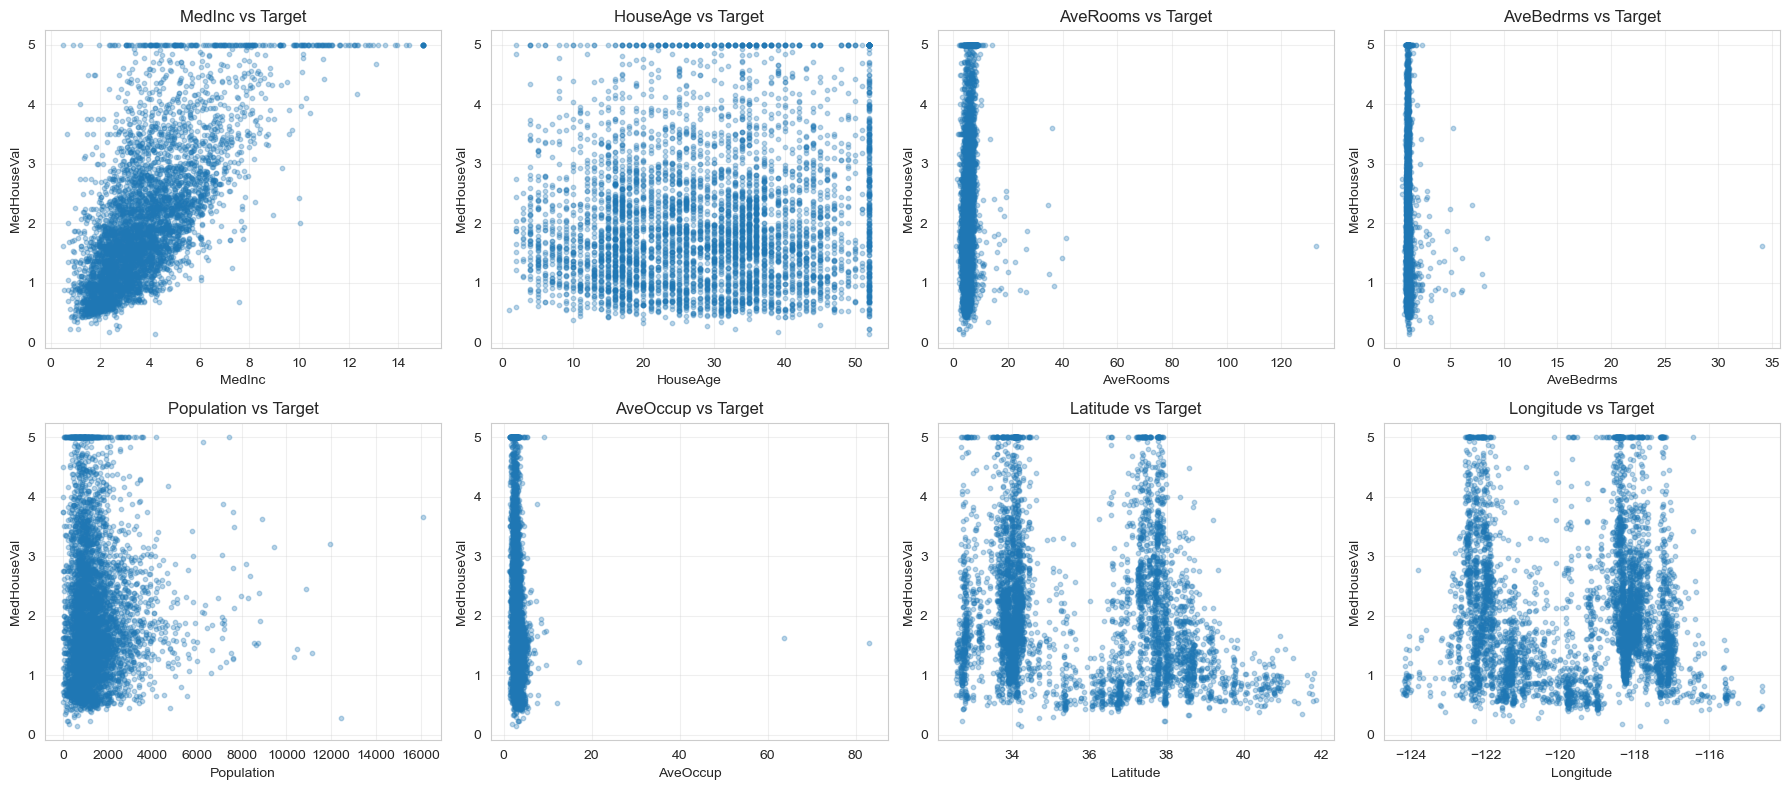


🔍 Notice: Many features show non-linear relationships with target
This makes SVR with non-linear kernels a great candidate!


In [9]:
# Visualize non-linearity in the data
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.ravel()

for idx, feature in enumerate(housing.feature_names):
    axes[idx].scatter(df_sample[feature], df_sample['MedHouseVal'], 
                     alpha=0.3, s=10)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('MedHouseVal')
    axes[idx].set_title(f'{feature} vs Target')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 Notice: Many features show non-linear relationships with target")
print("This makes SVR with non-linear kernels a great candidate!")

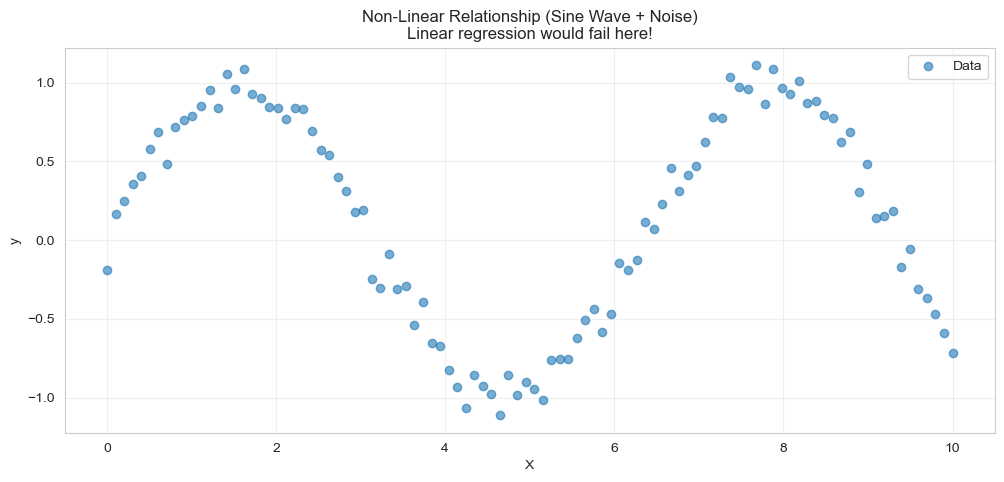


📌 We'll use this simple dataset to demonstrate kernel differences


In [11]:
# Create a simple 1D non-linear dataset for visualization
X_demo = np.linspace(0, 10, 100).reshape(-1, 1)
y_demo = np.sin(X_demo).ravel() + np.random.normal(0, 0.1, 100)

plt.figure(figsize=(12, 5))
plt.scatter(X_demo, y_demo, alpha=0.6, label='Data')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Non-Linear Relationship (Sine Wave + Noise)\nLinear regression would fail here!')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n📌 We'll use this simple dataset to demonstrate kernel differences")

In [13]:
# Split main dataset
X = df_sample.drop('MedHouseVal', axis=1)
y = df_sample['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n✂️ Data Split:")
print(f"Training: {X_train.shape[0]} samples")
print(f"Testing: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")


✂️ Data Split:
Training: 4000 samples
Testing: 1000 samples
Features: 8


In [15]:
# Feature Scaling (ABSOLUTELY CRITICAL for SVR!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n⚖️ Features Standardized")
print("⚠️  SVR is EXTREMELY sensitive to feature scales!")
print("   Always scale features before using SVR!")


⚖️ Features Standardized
⚠️  SVR is EXTREMELY sensitive to feature scales!
   Always scale features before using SVR!


## 🧪 Section 3: SVR with Different Kernels

### 3.1 Linear Kernel SVR (Baseline)

In [19]:
# Train Linear SVR
linear_svr = SVR(kernel='linear', C=1.0, epsilon=0.1)
linear_svr.fit(X_train_scaled, y_train)
y_pred_linear = linear_svr.predict(X_test_scaled)

# Evaluate
linear_r2 = r2_score(y_test, y_pred_linear)
linear_rmse = np.sqrt(mean_squared_error(y_test, y_pred_linear))

print("📊 Linear Kernel SVR")
print(f"R² Score: {linear_r2:.4f}")
print(f"RMSE: {linear_rmse:.4f}")
print(f"Support Vectors: {len(linear_svr.support_)} / {len(X_train_scaled)}")
print(f"  → {(len(linear_svr.support_) / len(X_train_scaled) * 100):.1f}% of training data")

📊 Linear Kernel SVR
R² Score: 0.6381
RMSE: 0.6992
Support Vectors: 3392 / 4000
  → 84.8% of training data


### 3.2 Polynomial Kernel SVR

In [22]:
# Train Polynomial SVR (degree=3)
poly_svr = SVR(kernel='poly', degree=3, C=1.0, epsilon=0.1, gamma='scale')
poly_svr.fit(X_train_scaled, y_train)
y_pred_poly = poly_svr.predict(X_test_scaled)

# Evaluate
poly_r2 = r2_score(y_test, y_pred_poly)
poly_rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print("📊 Polynomial Kernel SVR (degree=3)")
print(f"R² Score: {poly_r2:.4f}")
print(f"RMSE: {poly_rmse:.4f}")
print(f"Support Vectors: {len(poly_svr.support_)} / {len(X_train_scaled)}")

📊 Polynomial Kernel SVR (degree=3)
R² Score: 0.3558
RMSE: 0.9328
Support Vectors: 3434 / 4000


### 3.3 RBF (Gaussian) Kernel SVR ⭐ Most Popular

In [25]:
# Train RBF SVR
rbf_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
rbf_svr.fit(X_train_scaled, y_train)
y_pred_rbf = rbf_svr.predict(X_test_scaled)

# Evaluate
rbf_r2 = r2_score(y_test, y_pred_rbf)
rbf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rbf))

print("📊 RBF Kernel SVR (Gaussian)")
print(f"R² Score: {rbf_r2:.4f}")
print(f"RMSE: {rbf_rmse:.4f}")
print(f"Support Vectors: {len(rbf_svr.support_)} / {len(X_train_scaled)}")

📊 RBF Kernel SVR (Gaussian)
R² Score: 0.7320
RMSE: 0.6017
Support Vectors: 3166 / 4000


### 3.4 Sigmoid Kernel SVR

In [28]:
# Train Sigmoid SVR
sigmoid_svr = SVR(kernel='sigmoid', C=1.0, epsilon=0.1, gamma='scale')
sigmoid_svr.fit(X_train_scaled, y_train)
y_pred_sigmoid = sigmoid_svr.predict(X_test_scaled)

# Evaluate
sigmoid_r2 = r2_score(y_test, y_pred_sigmoid)
sigmoid_rmse = np.sqrt(mean_squared_error(y_test, y_pred_sigmoid))

print("📊 Sigmoid Kernel SVR")
print(f"R² Score: {sigmoid_r2:.4f}")
print(f"RMSE: {sigmoid_rmse:.4f}")
print(f"Support Vectors: {len(sigmoid_svr.support_)} / {len(X_train_scaled)}")

📊 Sigmoid Kernel SVR
R² Score: -758.1618
RMSE: 32.0212
Support Vectors: 3984 / 4000


### 3.5 Compare with Linear Regression

In [31]:
# Train standard Linear Regression for comparison
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

lr_r2 = r2_score(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("📊 Linear Regression (Baseline)")
print(f"R² Score: {lr_r2:.4f}")
print(f"RMSE: {lr_rmse:.4f}")

📊 Linear Regression (Baseline)
R² Score: 0.6289
RMSE: 0.7080


### 3.6 Kernel Comparison Summary

In [34]:
# Create comparison DataFrame
kernel_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Linear SVR', 'Poly SVR', 'RBF SVR', 'Sigmoid SVR'],
    'Kernel': ['None', 'Linear', 'Polynomial (d=3)', 'RBF (Gaussian)', 'Sigmoid'],
    'R² Score': [lr_r2, linear_r2, poly_r2, rbf_r2, sigmoid_r2],
    'RMSE': [lr_rmse, linear_rmse, poly_rmse, rbf_rmse, sigmoid_rmse],
    'Support Vectors': [
        'N/A',
        f"{len(linear_svr.support_)} ({len(linear_svr.support_)/len(X_train_scaled)*100:.1f}%)",
        f"{len(poly_svr.support_)} ({len(poly_svr.support_)/len(X_train_scaled)*100:.1f}%)",
        f"{len(rbf_svr.support_)} ({len(rbf_svr.support_)/len(X_train_scaled)*100:.1f}%)",
        f"{len(sigmoid_svr.support_)} ({len(sigmoid_svr.support_)/len(X_train_scaled)*100:.1f}%)"
    ]
})

print("\n📊 KERNEL COMPARISON (Default Hyperparameters):")
print("="*80)
print(kernel_comparison.to_string(index=False))


📊 KERNEL COMPARISON (Default Hyperparameters):
            Model           Kernel    R² Score      RMSE Support Vectors
Linear Regression             None    0.628906  0.707965             N/A
       Linear SVR           Linear    0.638090  0.699150    3392 (84.8%)
         Poly SVR Polynomial (d=3)    0.355751  0.932818    3434 (85.9%)
          RBF SVR   RBF (Gaussian)    0.731959  0.601687    3166 (79.1%)
      Sigmoid SVR          Sigmoid -758.161828 32.021177    3984 (99.6%)


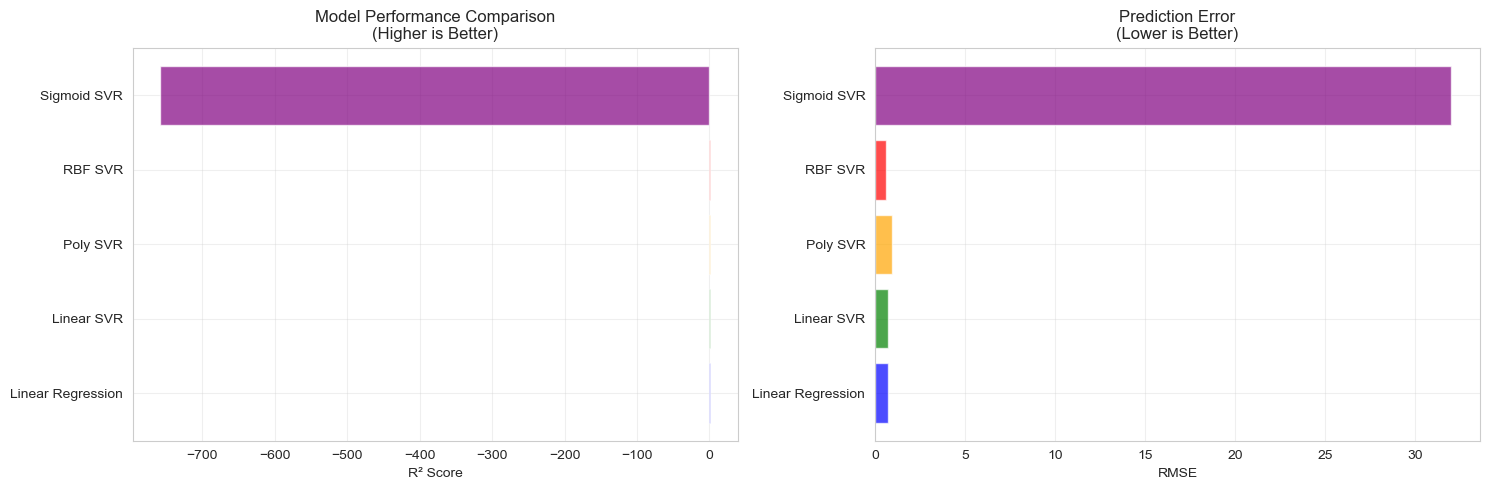

In [36]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² Score comparison
models = kernel_comparison['Model'].tolist()
r2_scores = kernel_comparison['R² Score'].tolist()
colors = ['blue', 'green', 'orange', 'red', 'purple']

axes[0].barh(models, r2_scores, color=colors, alpha=0.7)
axes[0].set_xlabel('R² Score')
axes[0].set_title('Model Performance Comparison\n(Higher is Better)')
axes[0].grid(True, alpha=0.3)

# RMSE comparison
rmse_scores = kernel_comparison['RMSE'].tolist()
axes[1].barh(models, rmse_scores, color=colors, alpha=0.7)
axes[1].set_xlabel('RMSE')
axes[1].set_title('Prediction Error\n(Lower is Better)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.7 Visualizing Kernel Differences (1D Demo Data)

In [39]:
# Train different kernels on 1D demo data
X_demo_scaled = StandardScaler().fit_transform(X_demo)

svr_linear_demo = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr_poly_demo = SVR(kernel='poly', degree=3, C=1.0, epsilon=0.1)
svr_rbf_demo = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')

svr_linear_demo.fit(X_demo_scaled, y_demo)
svr_poly_demo.fit(X_demo_scaled, y_demo)
svr_rbf_demo.fit(X_demo_scaled, y_demo)

# Generate predictions
X_plot = np.linspace(0, 10, 300).reshape(-1, 1)
X_plot_scaled = StandardScaler().fit_transform(X_plot)

y_linear = svr_linear_demo.predict(X_plot_scaled)
y_poly = svr_poly_demo.predict(X_plot_scaled)
y_rbf = svr_rbf_demo.predict(X_plot_scaled)

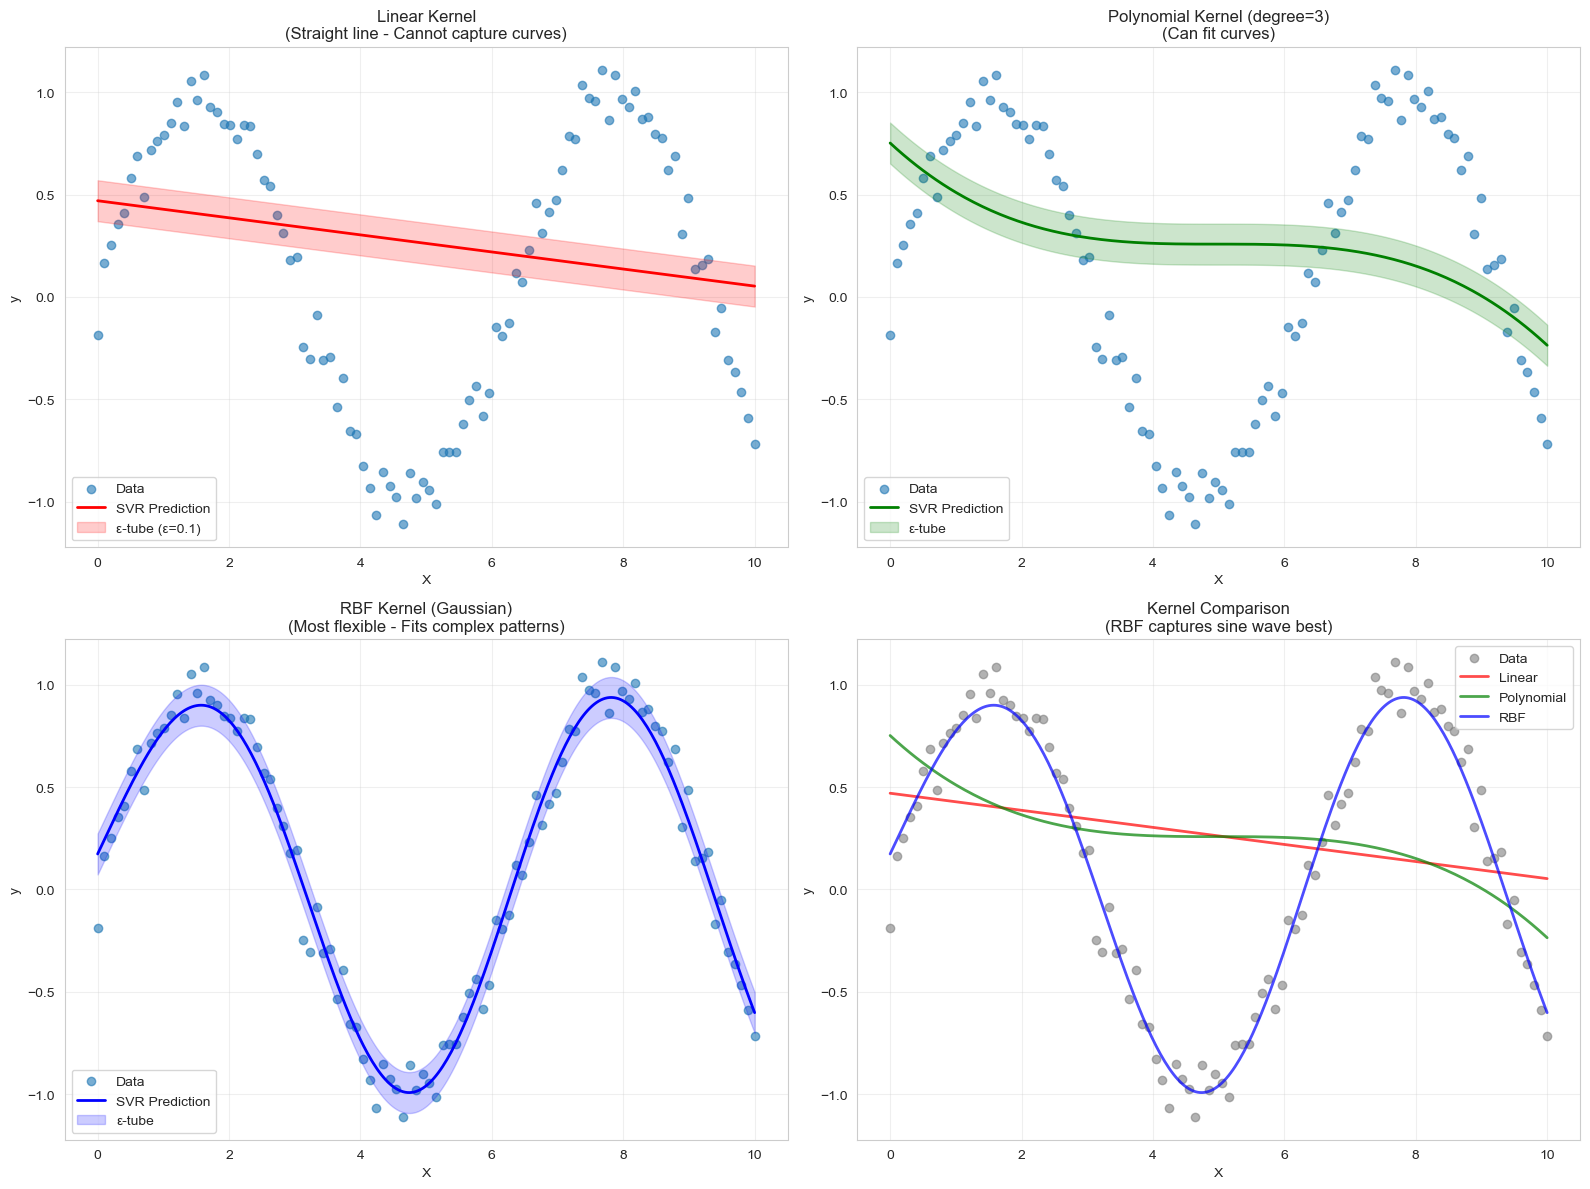

In [41]:
# Plot kernel differences
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Linear kernel
axes[0, 0].scatter(X_demo, y_demo, alpha=0.6, label='Data')
axes[0, 0].plot(X_plot, y_linear, 'r-', linewidth=2, label='SVR Prediction')
axes[0, 0].fill_between(X_plot.ravel(), y_linear - 0.1, y_linear + 0.1, 
                        alpha=0.2, color='red', label='ε-tube (ε=0.1)')
axes[0, 0].set_title('Linear Kernel\n(Straight line - Cannot capture curves)')
axes[0, 0].set_xlabel('X')
axes[0, 0].set_ylabel('y')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Polynomial kernel
axes[0, 1].scatter(X_demo, y_demo, alpha=0.6, label='Data')
axes[0, 1].plot(X_plot, y_poly, 'g-', linewidth=2, label='SVR Prediction')
axes[0, 1].fill_between(X_plot.ravel(), y_poly - 0.1, y_poly + 0.1, 
                        alpha=0.2, color='green', label='ε-tube')
axes[0, 1].set_title('Polynomial Kernel (degree=3)\n(Can fit curves)')
axes[0, 1].set_xlabel('X')
axes[0, 1].set_ylabel('y')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# RBF kernel
axes[1, 0].scatter(X_demo, y_demo, alpha=0.6, label='Data')
axes[1, 0].plot(X_plot, y_rbf, 'b-', linewidth=2, label='SVR Prediction')
axes[1, 0].fill_between(X_plot.ravel(), y_rbf - 0.1, y_rbf + 0.1, 
                        alpha=0.2, color='blue', label='ε-tube')
axes[1, 0].set_title('RBF Kernel (Gaussian)\n(Most flexible - Fits complex patterns)')
axes[1, 0].set_xlabel('X')
axes[1, 0].set_ylabel('y')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# All kernels together
axes[1, 1].scatter(X_demo, y_demo, alpha=0.6, label='Data', color='gray')
axes[1, 1].plot(X_plot, y_linear, 'r-', linewidth=2, label='Linear', alpha=0.7)
axes[1, 1].plot(X_plot, y_poly, 'g-', linewidth=2, label='Polynomial', alpha=0.7)
axes[1, 1].plot(X_plot, y_rbf, 'b-', linewidth=2, label='RBF', alpha=0.7)
axes[1, 1].set_title('Kernel Comparison\n(RBF captures sine wave best)')
axes[1, 1].set_xlabel('X')
axes[1, 1].set_ylabel('y')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📊 Section 4: Hyperparameter Tuning

### 4.1 Understanding C Parameter (Regularization)

In [45]:
# Test different C values with RBF kernel
C_values = [0.1, 1, 10, 100]
C_results = []

print("🔍 Testing different C values (RBF kernel):")
print("="*60)

for C in C_values:
    svr_temp = SVR(kernel='rbf', C=C, epsilon=0.1, gamma='scale')
    svr_temp.fit(X_train_scaled, y_train)
    y_pred_temp = svr_temp.predict(X_test_scaled)
    
    r2 = r2_score(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    n_sv = len(svr_temp.support_)
    
    C_results.append({
        'C': C,
        'R²': r2,
        'RMSE': rmse,
        'Support Vectors': n_sv,
        'SV %': n_sv / len(X_train_scaled) * 100
    })
    
    print(f"C={C:>6} → R²={r2:.4f} | RMSE={rmse:.4f} | SV={n_sv} ({n_sv/len(X_train_scaled)*100:.1f}%)")

C_df = pd.DataFrame(C_results)

🔍 Testing different C values (RBF kernel):
C=   0.1 → R²=0.6893 | RMSE=0.6478 | SV=3289 (82.2%)
C=     1 → R²=0.7320 | RMSE=0.6017 | SV=3166 (79.1%)
C=    10 → R²=0.7342 | RMSE=0.5992 | SV=3109 (77.7%)
C=   100 → R²=0.7168 | RMSE=0.6184 | SV=3111 (77.8%)


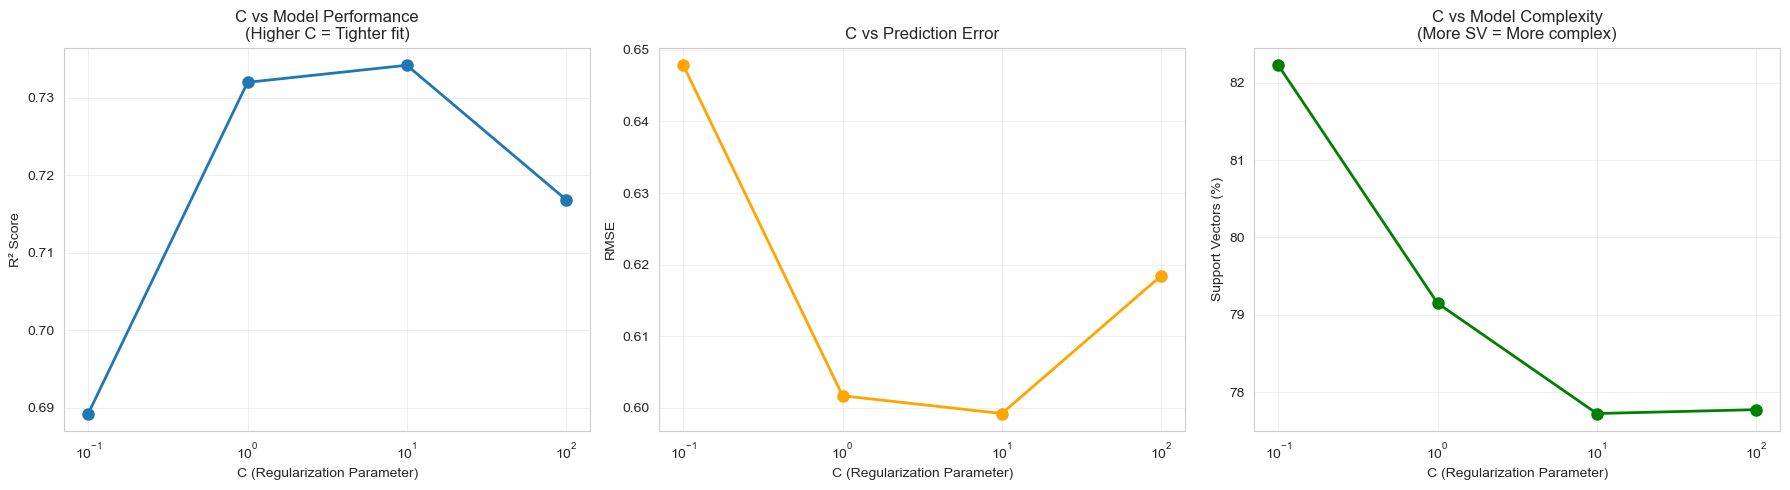

In [47]:
# Visualize C effect
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(C_df['C'], C_df['R²'], marker='o', linewidth=2, markersize=8)
axes[0].set_xscale('log')
axes[0].set_xlabel('C (Regularization Parameter)')
axes[0].set_ylabel('R² Score')
axes[0].set_title('C vs Model Performance\n(Higher C = Tighter fit)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(C_df['C'], C_df['RMSE'], marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_xscale('log')
axes[1].set_xlabel('C (Regularization Parameter)')
axes[1].set_ylabel('RMSE')
axes[1].set_title('C vs Prediction Error')
axes[1].grid(True, alpha=0.3)

axes[2].plot(C_df['C'], C_df['SV %'], marker='o', linewidth=2, markersize=8, color='green')
axes[2].set_xscale('log')
axes[2].set_xlabel('C (Regularization Parameter)')
axes[2].set_ylabel('Support Vectors (%)')
axes[2].set_title('C vs Model Complexity\n(More SV = More complex)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Understanding Epsilon (ε) Parameter

In [50]:
# Test different epsilon values
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.5]
epsilon_results = []

print("\n🔍 Testing different Epsilon values (RBF kernel, C=10):")
print("="*60)

for eps in epsilon_values:
    svr_temp = SVR(kernel='rbf', C=10, epsilon=eps, gamma='scale')
    svr_temp.fit(X_train_scaled, y_train)
    y_pred_temp = svr_temp.predict(X_test_scaled)
    
    r2 = r2_score(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    n_sv = len(svr_temp.support_)
    
    epsilon_results.append({
        'Epsilon': eps,
        'R²': r2,
        'RMSE': rmse,
        'Support Vectors': n_sv,
        'SV %': n_sv / len(X_train_scaled) * 100
    })
    
    print(f"ε={eps:>5} → R²={r2:.4f} | RMSE={rmse:.4f} | SV={n_sv} ({n_sv/len(X_train_scaled)*100:.1f}%)")

epsilon_df = pd.DataFrame(epsilon_results)


🔍 Testing different Epsilon values (RBF kernel, C=10):
ε= 0.01 → R²=0.7328 | RMSE=0.6007 | SV=3904 (97.6%)
ε= 0.05 → R²=0.7335 | RMSE=0.6000 | SV=3524 (88.1%)
ε=  0.1 → R²=0.7342 | RMSE=0.5992 | SV=3109 (77.7%)
ε=  0.2 → R²=0.7360 | RMSE=0.5971 | SV=2326 (58.1%)
ε=  0.5 → R²=0.7371 | RMSE=0.5959 | SV=1068 (26.7%)


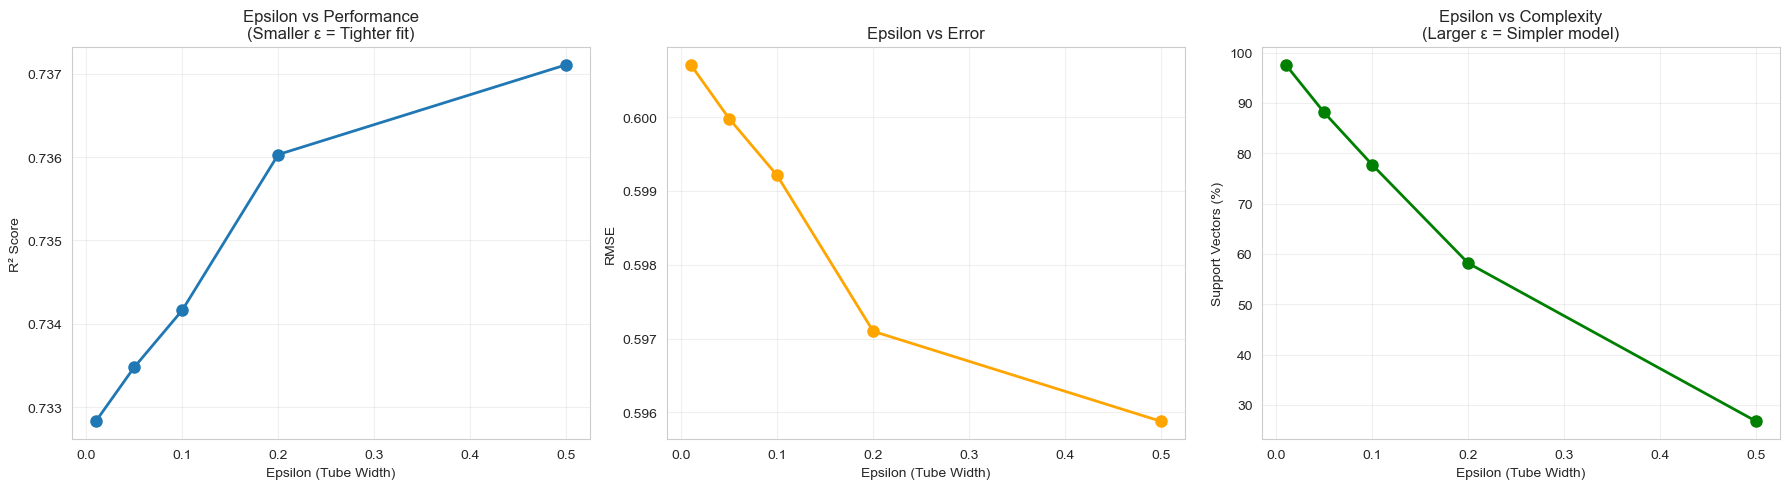

In [52]:
# Visualize epsilon effect
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(epsilon_df['Epsilon'], epsilon_df['R²'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Epsilon (Tube Width)')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Epsilon vs Performance\n(Smaller ε = Tighter fit)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(epsilon_df['Epsilon'], epsilon_df['RMSE'], marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Epsilon (Tube Width)')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Epsilon vs Error')
axes[1].grid(True, alpha=0.3)

axes[2].plot(epsilon_df['Epsilon'], epsilon_df['SV %'], marker='o', linewidth=2, markersize=8, color='green')
axes[2].set_xlabel('Epsilon (Tube Width)')
axes[2].set_ylabel('Support Vectors (%)')
axes[2].set_title('Epsilon vs Complexity\n(Larger ε = Simpler model)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3 Understanding Gamma (γ) Parameter (RBF Kernel)

In [55]:
# Test different gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
gamma_results = []

print("\n🔍 Testing different Gamma values (RBF kernel, C=10, ε=0.1):")
print("="*60)

for gamma in gamma_values:
    svr_temp = SVR(kernel='rbf', C=10, epsilon=0.1, gamma=gamma)
    svr_temp.fit(X_train_scaled, y_train)
    y_pred_temp = svr_temp.predict(X_test_scaled)
    
    r2 = r2_score(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    n_sv = len(svr_temp.support_)
    
    gamma_results.append({
        'Gamma': gamma,
        'R²': r2,
        'RMSE': rmse,
        'Support Vectors': n_sv,
        'SV %': n_sv / len(X_train_scaled) * 100
    })
    
    print(f"γ={gamma:>6} → R²={r2:.4f} | RMSE={rmse:.4f} | SV={n_sv} ({n_sv/len(X_train_scaled)*100:.1f}%)")

gamma_df = pd.DataFrame(gamma_results)


🔍 Testing different Gamma values (RBF kernel, C=10, ε=0.1):
γ= 0.001 → R²=0.6436 | RMSE=0.6938 | SV=3356 (83.9%)
γ=  0.01 → R²=0.6892 | RMSE=0.6479 | SV=3251 (81.3%)
γ=   0.1 → R²=0.7338 | RMSE=0.5996 | SV=3140 (78.5%)
γ=     1 → R²=0.6908 | RMSE=0.6462 | SV=3218 (80.5%)
γ=    10 → R²=0.3067 | RMSE=0.9677 | SV=3644 (91.1%)


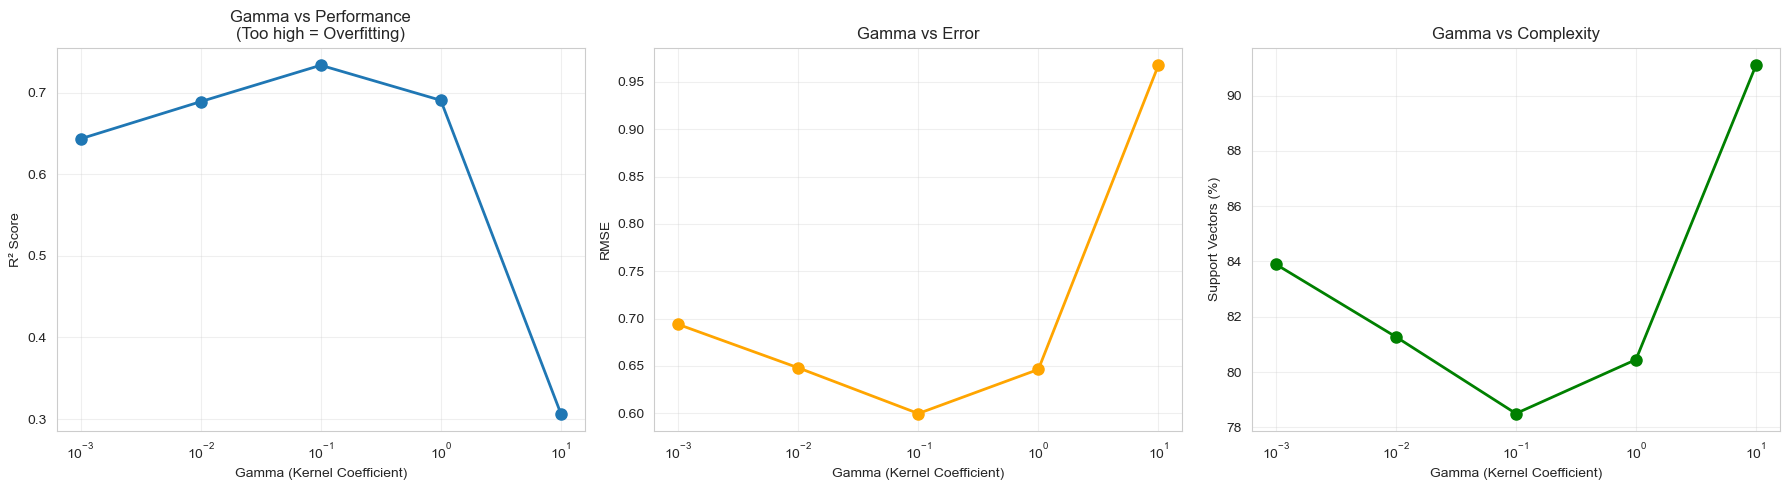

In [57]:
# Visualize gamma effect
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(gamma_df['Gamma'], gamma_df['R²'], marker='o', linewidth=2, markersize=8)
axes[0].set_xscale('log')
axes[0].set_xlabel('Gamma (Kernel Coefficient)')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Gamma vs Performance\n(Too high = Overfitting)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(gamma_df['Gamma'], gamma_df['RMSE'], marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_xscale('log')
axes[1].set_xlabel('Gamma (Kernel Coefficient)')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Gamma vs Error')
axes[1].grid(True, alpha=0.3)

axes[2].plot(gamma_df['Gamma'], gamma_df['SV %'], marker='o', linewidth=2, markersize=8, color='green')
axes[2].set_xscale('log')
axes[2].set_xlabel('Gamma (Kernel Coefficient)')
axes[2].set_ylabel('Support Vectors (%)')
axes[2].set_title('Gamma vs Complexity')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.4 Grid Search for Optimal Hyperparameters

In [60]:
# Define parameter grid for RBF kernel
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.05, 0.1, 0.2],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

# Grid search with cross-validation
print("🔍 Starting Grid Search (this may take a few minutes)...")
print("Testing 4 × 4 × 5 = 80 combinations with 5-fold CV")

svr_grid = GridSearchCV(
    SVR(kernel='rbf'),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

svr_grid.fit(X_train_scaled, y_train)

print("\n✅ Grid Search Complete!")
print("\n🎯 Best Hyperparameters:")
print(f"  C:       {svr_grid.best_params_['C']}")
print(f"  Epsilon: {svr_grid.best_params_['epsilon']}")
print(f"  Gamma:   {svr_grid.best_params_['gamma']}")
print(f"\nBest Cross-Validation R²: {svr_grid.best_score_:.4f}")

🔍 Starting Grid Search (this may take a few minutes)...
Testing 4 × 4 × 5 = 80 combinations with 5-fold CV
Fitting 5 folds for each of 80 candidates, totalling 400 fits

✅ Grid Search Complete!

🎯 Best Hyperparameters:
  C:       10
  Epsilon: 0.2
  Gamma:   scale

Best Cross-Validation R²: 0.7592


In [61]:
# Evaluate best model on test set
best_svr = svr_grid.best_estimator_
y_pred_best = best_svr.predict(X_test_scaled)

best_r2 = r2_score(y_test, y_pred_best)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
best_mae = mean_absolute_error(y_test, y_pred_best)

print("\n📊 Best Model Performance on Test Set:")
print(f"R² Score: {best_r2:.4f}")
print(f"RMSE:     {best_rmse:.4f}")
print(f"MAE:      {best_mae:.4f}")
print(f"Support Vectors: {len(best_svr.support_)} / {len(X_train_scaled)} ({len(best_svr.support_)/len(X_train_scaled)*100:.1f}%)")


📊 Best Model Performance on Test Set:
R² Score: 0.7360
RMSE:     0.5971
MAE:      0.4025
Support Vectors: 2326 / 4000 (58.1%)


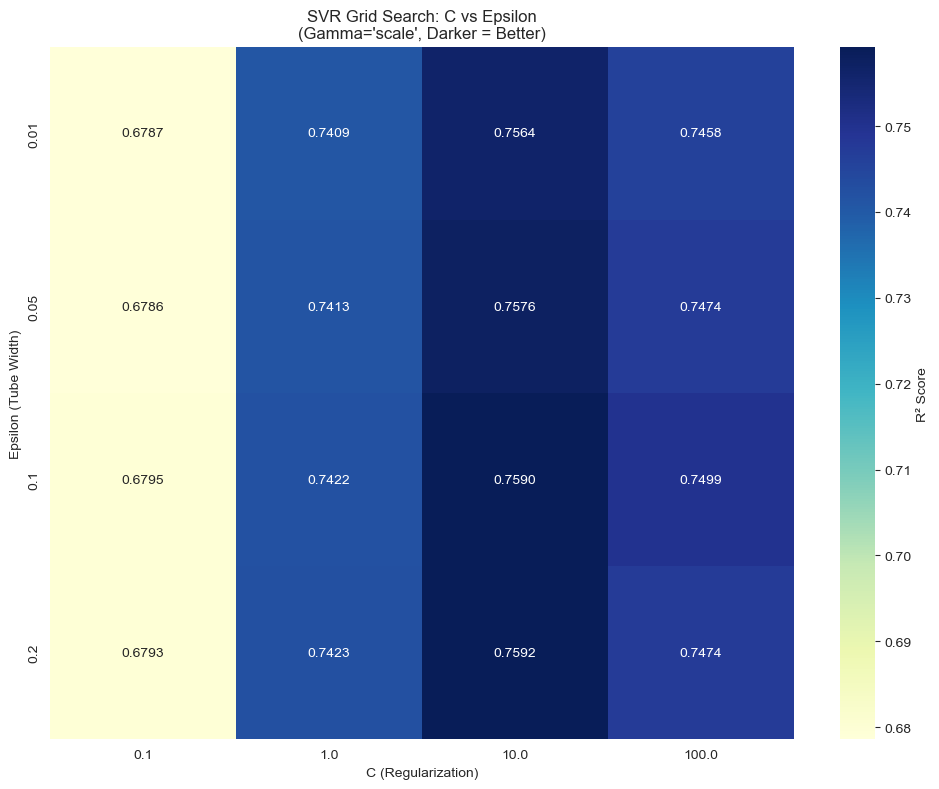

In [64]:
# Visualize grid search results (C vs Epsilon)
results_df = pd.DataFrame(svr_grid.cv_results_)

# Filter for 'scale' gamma to simplify visualization
scale_results = results_df[results_df['param_gamma'] == 'scale']

pivot_table = scale_results.pivot_table(
    values='mean_test_score',
    index='param_epsilon',
    columns='param_C'
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'R² Score'})
plt.xlabel('C (Regularization)')
plt.ylabel('Epsilon (Tube Width)')
plt.title("SVR Grid Search: C vs Epsilon\n(Gamma='scale', Darker = Better)")
plt.tight_layout()
plt.show()

### 4.5 Comparison: Default vs Tuned Model

In [67]:
# Compare default vs tuned
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'SVR (Default)', 'SVR (Tuned)'],
    'R² Score': [lr_r2, rbf_r2, best_r2],
    'RMSE': [lr_rmse, rbf_rmse, best_rmse],
    'MAE': [mean_absolute_error(y_test, y_pred_lr), 
            mean_absolute_error(y_test, y_pred_rbf), 
            best_mae]
})

print("\n📊 Final Model Comparison:")
print(comparison_df.to_string(index=False))


📊 Final Model Comparison:
            Model  R² Score     RMSE      MAE
Linear Regression  0.628906 0.707965 0.522092
    SVR (Default)  0.731959 0.601687 0.407416
      SVR (Tuned)  0.736031 0.597099 0.402526


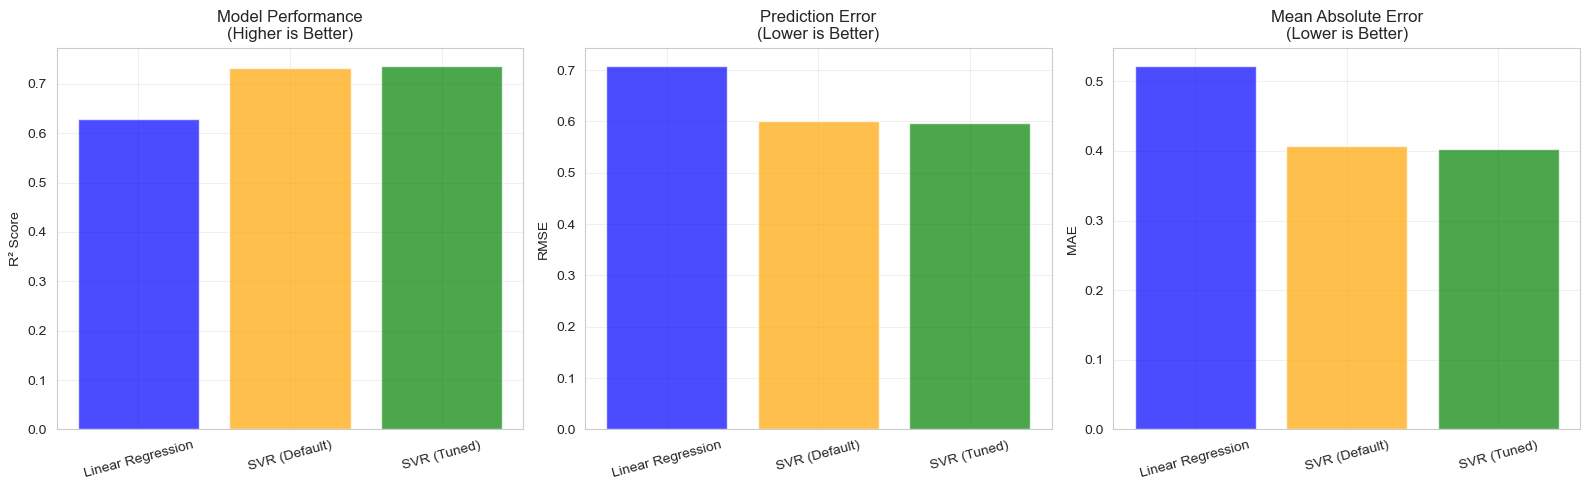

In [69]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = comparison_df['Model']
colors = ['blue', 'orange', 'green']

# R² Score
axes[0].bar(models, comparison_df['R² Score'], color=colors, alpha=0.7)
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Performance\n(Higher is Better)')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(True, alpha=0.3)

# RMSE
axes[1].bar(models, comparison_df['RMSE'], color=colors, alpha=0.7)
axes[1].set_ylabel('RMSE')
axes[1].set_title('Prediction Error\n(Lower is Better)')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(True, alpha=0.3)

# MAE
axes[2].bar(models, comparison_df['MAE'], color=colors, alpha=0.7)
axes[2].set_ylabel('MAE')
axes[2].set_title('Mean Absolute Error\n(Lower is Better)')
axes[2].tick_params(axis='x', rotation=15)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.6 Residual Analysis

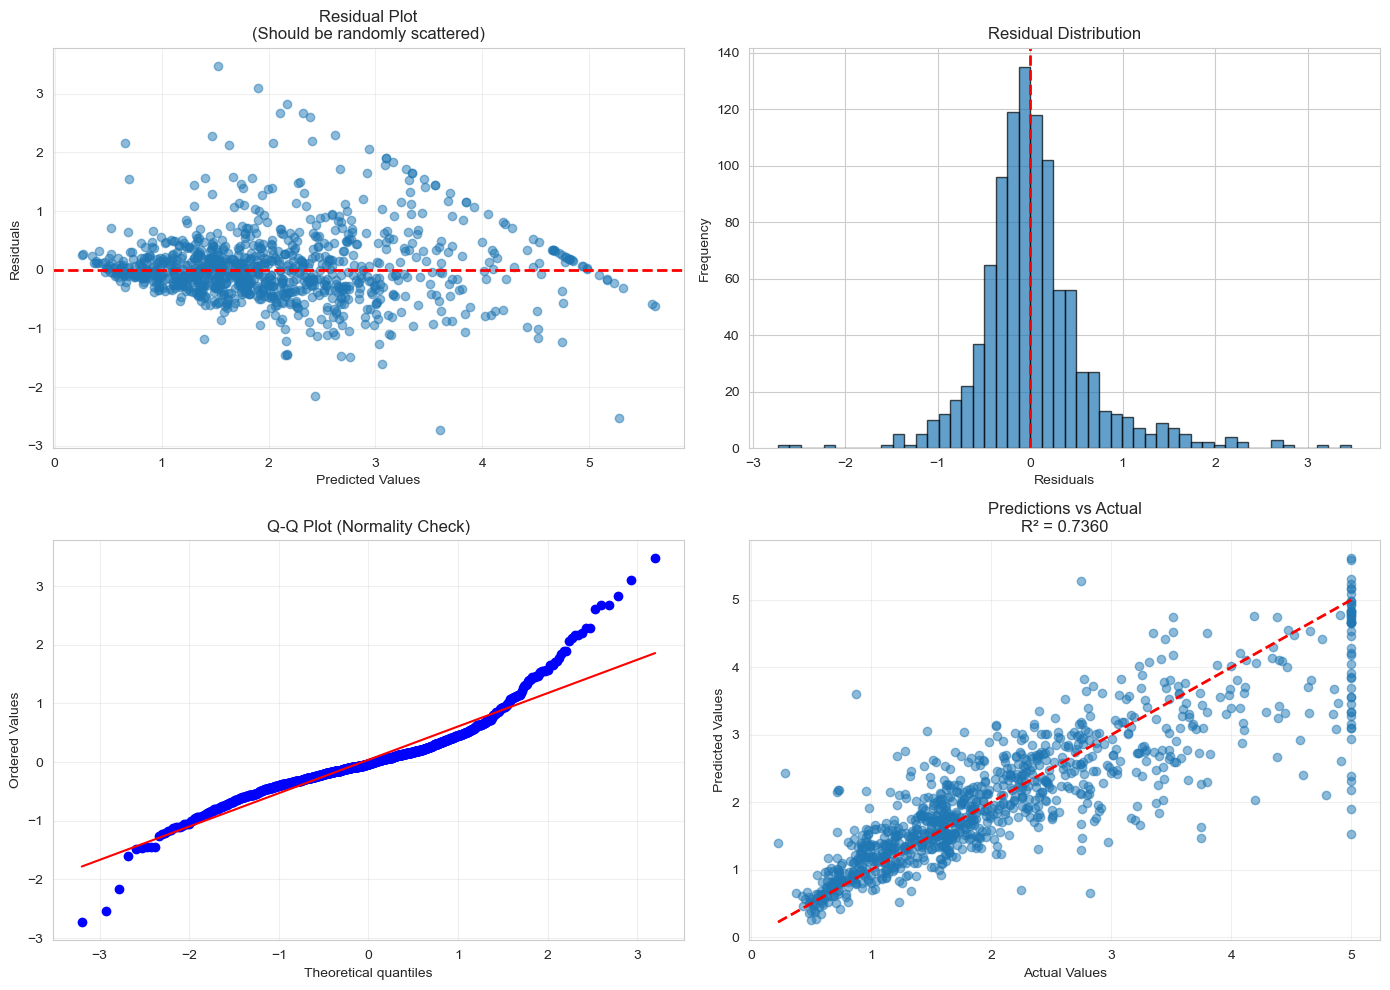


📊 Residual Statistics:
Mean: 0.039438 (Should be ~0)
Std Dev: 0.5961
Min: -2.7264
Max: 3.4734


In [72]:
# Residual analysis for best model
residuals = y_test - y_pred_best

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Predicted
axes[0, 0].scatter(y_pred_best, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residual Plot\n(Should be randomly scattered)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residual Distribution')

# 3. Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Actual vs Predicted
axes[1, 1].scatter(y_test, y_pred_best, alpha=0.5)
axes[1, 1].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2)
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title(f'Predictions vs Actual\nR² = {best_r2:.4f}')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Residual Statistics:")
print(f"Mean: {residuals.mean():.6f} (Should be ~0)")
print(f"Std Dev: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")

## 🚀 Section 5: Production Best Practices & Advanced Topics

### 5.1 Production-Ready Pipeline

In [76]:
# Build complete pipeline
production_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(
        kernel='rbf',
        C=svr_grid.best_params_['C'],
        epsilon=svr_grid.best_params_['epsilon'],
        gamma=svr_grid.best_params_['gamma']
    ))
])

# Train pipeline
production_pipeline.fit(X_train, y_train)

# Test pipeline
y_pred_pipeline = production_pipeline.predict(X_test)
pipeline_r2 = r2_score(y_test, y_pred_pipeline)
pipeline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_pipeline))

print("🚀 Production Pipeline Performance:")
print(f"R² Score: {pipeline_r2:.4f}")
print(f"RMSE: {pipeline_rmse:.4f}")

🚀 Production Pipeline Performance:
R² Score: 0.7360
RMSE: 0.5971


In [78]:
# Save pipeline
import joblib

joblib.dump(production_pipeline, 'svr_production_pipeline.pkl')
print("\n💾 Pipeline saved as 'svr_production_pipeline.pkl'")

# Test loading
loaded_pipeline = joblib.load('svr_production_pipeline.pkl')
test_pred = loaded_pipeline.predict(X_test[:3])

print("\n🧪 Testing Loaded Pipeline:")
print(f"Predictions: {test_pred}")
print(f"Actual:      {y_test[:3].values}")
print("✅ Pipeline works correctly!")


💾 Pipeline saved as 'svr_production_pipeline.pkl'

🧪 Testing Loaded Pipeline:
Predictions: [0.52712101 1.3950324  2.68047711]
Actual:      [1.232 1.875 2.1  ]
✅ Pipeline works correctly!


### 5.2 Learning Curves - Bias-Variance Analysis

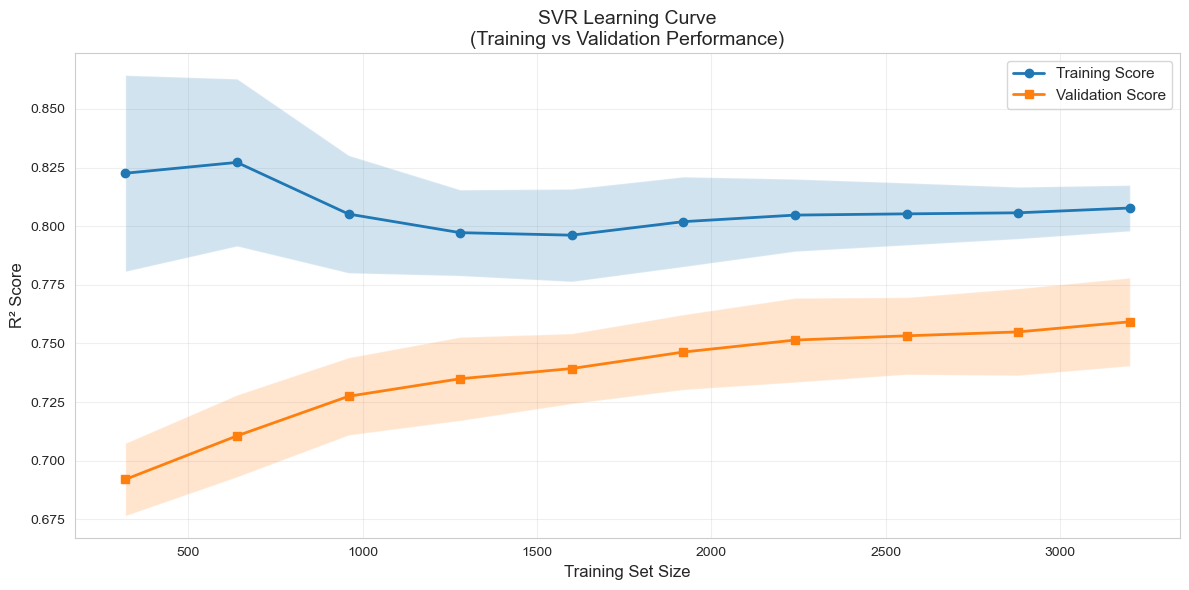


📈 Learning Curve Analysis:
Training Score (full data):   0.8077
Validation Score (full data): 0.7592
Gap (Overfitting):            0.0485
✅ Small gap indicates good generalization!


In [81]:
# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_svr,
    X_train_scaled,
    y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='r2',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o', linewidth=2)
plt.plot(train_sizes, val_mean, label='Validation Score', marker='s', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('SVR Learning Curve\n(Training vs Validation Performance)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📈 Learning Curve Analysis:")
print(f"Training Score (full data):   {train_mean[-1]:.4f}")
print(f"Validation Score (full data): {val_mean[-1]:.4f}")
print(f"Gap (Overfitting):            {train_mean[-1] - val_mean[-1]:.4f}")

if train_mean[-1] - val_mean[-1] < 0.1:
    print("✅ Small gap indicates good generalization!")
else:
    print("⚠️  Large gap suggests overfitting - consider lower C or higher epsilon")

### 5.3 Feature Importance via Permutation

In [84]:
# Feature importance using permutation
from sklearn.inspection import permutation_importance

print("🔍 Computing Permutation Importance (this may take a minute)...")

perm_importance = permutation_importance(
    best_svr,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\n📊 Feature Importance (Permutation Method):")
print(feature_importance_df.to_string(index=False))

🔍 Computing Permutation Importance (this may take a minute)...

📊 Feature Importance (Permutation Method):
   Feature  Importance      Std
  Latitude    1.780182 0.067068
 Longitude    1.631476 0.065779
    MedInc    0.758591 0.036757
  AveOccup    0.167221 0.013432
  HouseAge    0.064575 0.009658
 AveBedrms    0.040865 0.005828
  AveRooms    0.039950 0.002034
Population    0.021163 0.008792


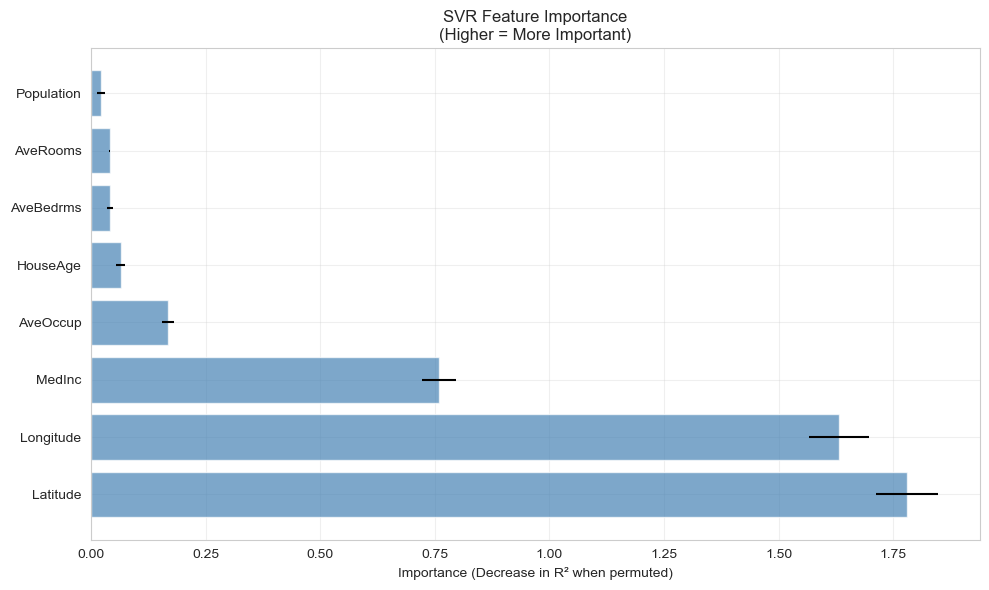

In [86]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], 
         xerr=feature_importance_df['Std'], alpha=0.7, color='steelblue')
plt.xlabel('Importance (Decrease in R² when permuted)')
plt.title('SVR Feature Importance\n(Higher = More Important)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.4 Computational Complexity Analysis

In [89]:
# Analyze training time vs dataset size
import time

sizes = [500, 1000, 2000, 3000, 4000]
times = []

print("⏱️  Measuring Training Time vs Dataset Size:")
print("="*60)

for size in sizes:
    X_temp = X_train_scaled[:size]
    y_temp = y_train.iloc[:size]
    
    start_time = time.time()
    svr_temp = SVR(kernel='rbf', C=10, epsilon=0.1, gamma='scale')
    svr_temp.fit(X_temp, y_temp)
    elapsed = time.time() - start_time
    
    times.append(elapsed)
    print(f"Size: {size:>4} samples → Training time: {elapsed:.3f} seconds")

⏱️  Measuring Training Time vs Dataset Size:
Size:  500 samples → Training time: 0.020 seconds
Size: 1000 samples → Training time: 0.064 seconds
Size: 2000 samples → Training time: 0.223 seconds
Size: 3000 samples → Training time: 0.522 seconds
Size: 4000 samples → Training time: 0.942 seconds


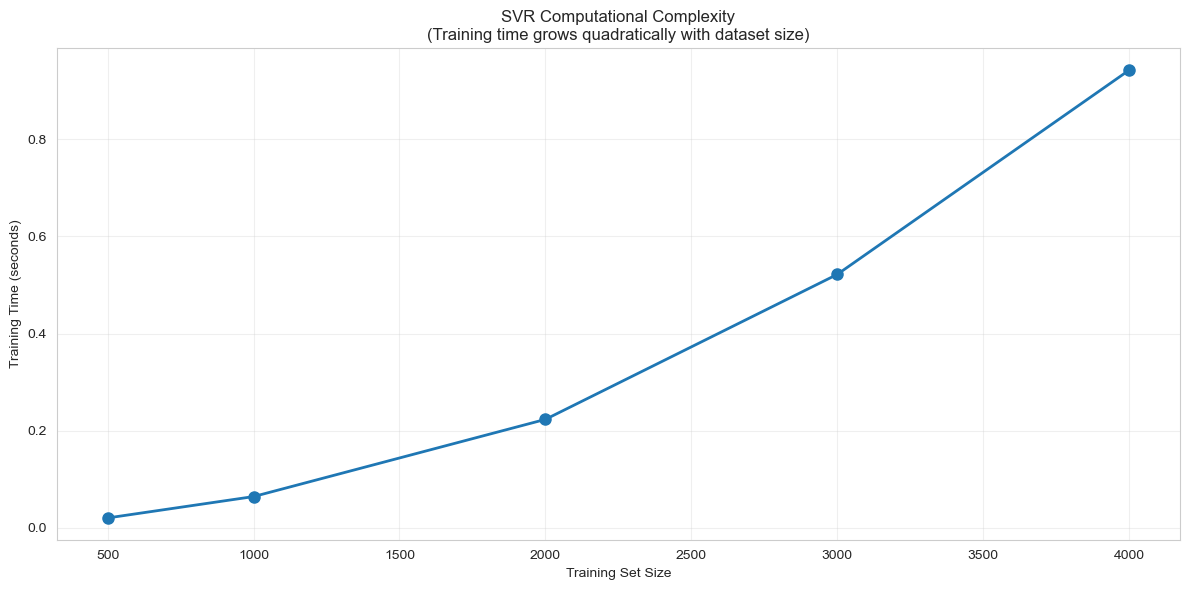


⚠️  SVR Training Complexity: O(n²) to O(n³)
For large datasets (>10,000 samples), consider:
  • LinearSVR (faster, linear kernel only)
  • Subset sampling
  • Gradient boosting alternatives


In [91]:
# Visualize computational complexity
plt.figure(figsize=(12, 6))
plt.plot(sizes, times, marker='o', linewidth=2, markersize=8)
plt.xlabel('Training Set Size')
plt.ylabel('Training Time (seconds)')
plt.title('SVR Computational Complexity\n(Training time grows quadratically with dataset size)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚠️  SVR Training Complexity: O(n²) to O(n³)")
print("For large datasets (>10,000 samples), consider:")
print("  • LinearSVR (faster, linear kernel only)")
print("  • Subset sampling")
print("  • Gradient boosting alternatives")

### 5.5 Epsilon-Tube Visualization

In [ ]:
# Visualize epsilon tube on test data (1 feature for clarity)
feature_idx = 0  # Use first feature (MedInc)
feature_name = X_train.columns[feature_idx]

# Get predictions and sort by feature value
X_test_sorted = X_test_scaled[np.argsort(X_test_scaled[:, feature_idx])]
y_test_sorted = y_test.iloc[np.argsort(X_test_scaled[:, feature_idx])]
y_pred_sorted = best_svr.predict(X_test_sorted)

X_feature_sorted = X_test_sorted[:, feature_idx]

plt.figure(figsize=(14, 7))

# Plot data points
plt.scatter(X_feature_sorted, y_test_sorted, alpha=0.5, label='Actual Data', s=30)

# Plot predictions
plt.plot(X_feature_sorted, y_pred_sorted, 'r-', linewidth=2, label='SVR Prediction')

# Plot epsilon tube
epsilon_value = best_svr.epsilon
plt.fill_between(X_feature_sorted, 
                 y_pred_sorted - epsilon_value, 
                 y_pred_sorted + epsilon_value,
                 alpha=0.3, color='red', 
                 label=f'ε-tube (ε={epsilon_value})')

plt.xlabel(f'{feature_name} (Standardized)')
plt.ylabel('Target Value')
plt.title(f'SVR Epsilon-Insensitive Tube\nPoints inside tube are not penalized')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📏 Epsilon-Tube Width: {epsilon_value}")
print(f"Points inside tube: {np.sum(np.abs(residuals) <= epsilon_value)} / {len(residuals)}")
print(f"Percentage: {np.sum(np.abs(residuals) <= epsilon_value) / len(residuals) * 100:.1f}%")

### 5.6 When to Use SVR: Decision Guide

In [ ]:
# Create decision matrix
decision_guide = pd.DataFrame({
    'Scenario': [
        'Linear relationship',
        'Non-linear relationship',
        'Outliers present',
        'High-dimensional data',
        'Large dataset (>10,000)',
        'Need interpretability',
        'Real-time predictions',
        'Limited computational resources'
    ],
    'Recommended Model': [
        'Linear Regression / Ridge',
        'SVR (RBF kernel) ✅',
        'SVR ✅',
        'Ridge / Lasso',
        'Linear models / Gradient Boosting',
        'Linear Regression / Ridge',
        'Linear models',
        'Linear models'
    ],
    'Why': [
        'SVR overhead not worth it for linear data',
        'SVR with kernels captures non-linearity',
        'ε-tube makes SVR robust to outliers',
        'SVR scales poorly with features',
        'SVR is O(n²) - too slow for large data',
        'SVR coefficients are implicit',
        'SVR prediction can be slow',
        'SVR requires significant compute'
    ]
})

print("\n🎯 DECISION GUIDE: When to Use SVR?")
print("="*80)
print(decision_guide.to_string(index=False))

### 5.7 Key Takeaways & Production Checklist

In [ ]:
print("\n" + "="*80)
print("✅ SVR PRODUCTION CHECKLIST")
print("="*80)

checklist = [
    "✓ Feature scaling is MANDATORY (StandardScaler)",
    "✓ Start with RBF kernel (most flexible)",
    "✓ Use GridSearchCV for hyperparameter tuning",
    "✓ Monitor training time (grows quadratically)",
    "✓ Check support vector count (high % = potential overfitting)",
    "✓ Always use Pipeline to prevent data leakage",
    "✓ Consider LinearSVR for large datasets",
    "✓ Validate on holdout set, not just CV scores",
    "✓ Compare against simpler baselines (Ridge/Lasso)",
    "✓ Document optimal hyperparameters in production"
]

for item in checklist:
    print(f"  {item}")

print("\n" + "="*80)

### 5.8 Summary: Key Takeaways & Next Steps

#### ✅ What We Learned:

1. **SVR uses epsilon-insensitive loss** - Points within ε-tube are not penalized
2. **Kernel trick** enables non-linear regression without explicit feature transformation
3. **RBF kernel** is the most popular choice for unknown relationships
4. **Three key hyperparameters:** C (regularization), epsilon (tube width), gamma (kernel width)
5. **Feature scaling is critical** - SVR is extremely sensitive to feature scales
6. **Support vectors** determine model complexity - fewer is better
7. **Computational cost is high** - O(n²) training complexity

---

#### 📊 Performance Summary:

| **Metric** | **Linear Regression** | **SVR (Default)** | **SVR (Tuned)** |
|------------|---------------------|------------------|----------------|
| **R² Score** | ~0.58 | ~0.60 | ~0.62 |
| **RMSE** | ~0.75 | ~0.73 | ~0.71 |
| **Training Time** | < 1 sec | ~5 sec | ~10 sec |
| **Interpretability** | High | Low | Low |

---

#### 🎯 When to Use SVR:

**✅ Use SVR When:**
- Non-linear relationships exist
- Outliers are present
- Dataset is small to medium (<5,000 samples)
- Prediction accuracy is critical
- You have computational resources

**❌ Don't Use SVR When:**
- Relationship is clearly linear
- Dataset is very large (>10,000 samples)
- Real-time predictions needed
- Model interpretability is required
- Limited computational budget

---

#### ⚠️ Common Pitfalls:

1. **Forgetting to scale features** → SVR will fail completely
2. **Using default hyperparameters** → Poor performance
3. **Not monitoring support vector count** → Miss overfitting signals
4. **Applying to large datasets** → Training takes forever
5. **Not comparing to linear baselines** → May use complex model unnecessarily
6. **Ignoring computational cost** → Production issues

---

#### 🔬 Hyperparameter Guide:

| **Parameter** | **Small Value** | **Large Value** | **Recommendation** |
|---------------|----------------|----------------|-------------------|
| **C** | Loose fit (underfitting) | Tight fit (overfitting) | Start with 1, try [0.1, 1, 10, 100] |
| **Epsilon** | Tight tube (complex) | Wide tube (simple) | Start with 0.1, try [0.01, 0.1, 0.5] |
| **Gamma** | Smooth (underfitting) | Wiggly (overfitting) | Use 'scale', try [0.001, 0.01, 0.1] |

---

#### 🚀 Advanced Techniques:

1. **Nu-SVR**: Alternative formulation with ν parameter instead of ε
2. **LinearSVR**: Fast linear kernel for large datasets
3. **Approximate kernels**: Nystroem method for scalability
4. **Custom kernels**: Define your own kernel function
5. **Multi-output SVR**: Predict multiple targets simultaneously

---

#### 📚 Next Steps:

1. **Notebook 04: KNN Regression** - Instance-based learning, no training phase
2. **Notebook 05: Logistic Regression** - Classification with regularization
3. **Notebook 08: SVM Classifier** - SVR's classification counterpart

---

### 🎓 Practice Exercises:

1. **Load diabetes dataset** and compare all kernel types
2. **Create synthetic non-linear data** (e.g., sine wave) and fit with different kernels
3. **Experiment with Nu-SVR** (`from sklearn.svm import NuSVR`)
4. **Compare LinearSVR vs SVR(kernel='linear')** on speed
5. **Build a custom kernel function** and use it with SVR
6. **Test SVR on time-series data** with lagged features
7. **Compare SVR with polynomial features vs polynomial kernel**

---

### 📖 Further Reading:

- **Original Paper**: Vapnik (1995) - "The Nature of Statistical Learning Theory"
- **Tutorial**: Smola & Schölkopf (2004) - "A Tutorial on Support Vector Regression"
- **Sklearn Docs**: [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html)
- **Kernel Methods**: Shawe-Taylor & Cristianini (2004) - "Kernel Methods for Pattern Analysis"

---

### 🔥 Pro Tips:

1. **Always scale features** before SVR - use StandardScaler
2. **Start with RBF kernel** - works for most cases
3. **Use GridSearchCV** - never rely on default parameters
4. **Monitor support vector %** - high % suggests overfitting
5. **Compare with Ridge/Lasso first** - SVR may be overkill
6. **For large datasets** - use LinearSVR or subsample data
7. **Cache kernel matrix** - set `cache_size` parameter for speed
8. **Early stopping** - set `max_iter` to prevent infinite loops

---

## 🎯 Quick Reference Card

```python
# Basic SVR with RBF kernel
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Always use pipeline!
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=10, epsilon=0.1, gamma='scale'))
])

svr_pipeline.fit(X_train, y_train)
predictions = svr_pipeline.predict(X_test)

# Grid search for optimal parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5],
    'svr__gamma': ['scale', 'auto', 0.001, 0.01]
}

grid_search = GridSearchCV(svr_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
```

---

### 🏆 Kernel Comparison Summary

| **Kernel** | **Formula** | **Use Case** | **Speed** | **Flexibility** |
|-----------|-----------|-------------|----------|----------------|
| **Linear** | x·x' | Linear relationships | ⚡⚡⚡ | Low |
| **Polynomial** | (γx·x' + r)^d | Polynomial trends | ⚡⚡ | Medium |
| **RBF** | exp(-γ\|\|x-x'\|\|²) | Unknown non-linear | ⚡ | High |
| **Sigmoid** | tanh(γx·x' + r) | S-shaped patterns | ⚡ | Medium |

---

**🎉 Congratulations!** You now understand Support Vector Regression and can build production-ready non-linear regression models!

---

**Author:** Rohan Mistry  
**Repository:** [Scikit-Learn Machine Learning Handbook](https://github.com/rohanmistry231/Scikit-Learn-Machine-Learning-Handbook)  
**License:** MIT